# Training a Neural Net

In [35]:
import os
import sys
import numpy
import math
import caffe

from pprint import pprint
from pylab import *
%matplotlib inline

import pandas as pd

# helper to show images in square
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0, canvas=plt):
    for im in data:
        pass
        #im -= im.min()
        #im /= im.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    if data.ndim == 4:
        canvas.imshow(data)
    else:
        canvas.imshow(data, cmap='gray')
        
caffe.set_device(0)
caffe.set_mode_gpu()

TRAIN_SIZE = 1024
TEST_SIZE = 2048
TRAIN_BATCH = 128
TEST_BATCH = 128
TRAIN_EPOCH = TRAIN_SIZE / TRAIN_BATCH
TEST_EPOCH = TEST_SIZE / TEST_BATCH

In [36]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 99999;

<IPython.core.display.Javascript object>

In [37]:
def define_solver(base_lr, weight_decay=0.005):
    return """# Generated from python.
    # Train Set
    #
    # Training net
    train_net: "temp/auto-train.prototxt"
    # Test net
    test_net: "temp/auto-test.prototxt"
    # These numbers don't matter, because we're running the test net ourselves.
    test_iter: 1
    test_interval: 100000
    # The base learning rate, momentum and the weight decay of the network.
    base_lr: %(base_lr)s
    momentum: 0.9
    weight_decay: %(weight_decay)s
    # The learning rate policy
    lr_policy: "step"
    gamma: 0.1
    # ~ 20 epochs rule of thumb from Karpathy
    stepsize: %(twenty_epochs)i
    # Display ~ every 5 epochs
    display: 100
    # The maximum number of iterations
    max_iter: 5000
    # snapshot intermediate results
    snapshot: 1000
    snapshot_prefix: "snap/lenet-2"
    # solver mode: CPU or GPU
    solver_mode: GPU""" % {
        'twenty_epochs': 20 * TRAIN_EPOCH,
        'base_lr': base_lr,
        'weight_decay': weight_decay
    }

from caffe import layers as L
from caffe import params as P

def define_net(lmdb, lmdb_labels, batch_size, mean_file):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    transform_param={
        'scale': 1./255,
        'mean_file': mean_file
    }
    n.data = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=transform_param, ntop=1)
    n.labels = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb_labels, ntop=1)
    
    n.conv1 = L.Convolution(n.data, kernel_size=7, stride=3, num_output=20, weight_filler=dict(type='xavier'))
    # n.relu1 = L.ReLU(n.conv1)
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.norm1 = L.LRN(n.pool1, alpha=0.0001, beta=0.75)
    
    n.conv2 = L.Convolution(n.norm1, kernel_size=5, pad=2, num_output=40, weight_filler=dict(type='xavier'))
    # n.relu2 = L.ReLU(n.conv2)
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=1, pool=P.Pooling.MAX)
    n.norm2 = L.LRN(n.pool2, alpha=0.0001, beta=0.75)

    n.conv3 = L.Convolution(n.norm2, kernel_size=3, pad=1, num_output=80, weight_filler=dict(type='xavier'))
    # n.relu3 = L.ReLU(n.conv3)
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.norm3 = L.LRN(n.pool3, alpha=0.0001, beta=0.75)

    n.ip1 = L.InnerProduct(n.norm3, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    
    n.ip2 = L.InnerProduct(n.relu1, num_output=21, weight_filler=dict(type='xavier'))
    
    n.reshape_labels = L.Reshape(n.labels, shape={'dim': [0,0]})
    n.loss = L.SigmoidCrossEntropyLoss(n.ip2, n.reshape_labels)
    return n.to_proto()

In [38]:
## Set up the network
def create_solver(base_lr, weight_decay, train_data, train_labels):
    with open('temp/autosolver.prototxt', 'w') as f:
        f.write(define_solver(base_lr, weight_decay))

    with open('temp/auto-train.prototxt', 'w') as f:
        f.write('name: "SeedNet"\n')
        f.write(str(define_net(train_data, train_labels, TRAIN_BATCH,
                               train_data + '_mean.binaryproto')))

    with open('temp/auto-test.prototxt', 'w') as f:
        f.write('name: "SeedNet"\n')
        f.write(str(define_net('temp/learnsat-val-lmdb',
                               'temp/classify/val-labels-lmdb',
                               TEST_BATCH,
                               train_data + '_mean.binaryproto')))

        
    solver = caffe.SGDSolver('temp/autosolver.prototxt')
    
    blob = caffe.proto.caffe_pb2.BlobProto()
    data = open( train_data + '_mean.binaryproto' , 'rb' ).read()
    blob.ParseFromString(data)
    arr = np.array( caffe.io.blobproto_to_array(blob) )
    mean_image = arr[0]

    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', mean_image)
    transformer.set_input_scale('data', 1./255)
    
    return solver, transformer

solver, transformer = create_solver(0.003,
                                    0,
                                    'temp/learnsat-subset-1024-train-lmdb',
                                    'temp/classify/train-1024-labels-lmdb')

classes = pd.read_csv('temp/class-list.csv', index_col='label', header=0)
print(classes)

# To get an idea of the architecture of our net, we can check the dimensions of 
# the intermediate features (blobs) and parameters (these will also be useful to 
# refer to when manipulating data later).

# each output is (batch size, feature dim, spatial dim)
pprint([(k, v.data.shape) for k, v in solver.net.blobs.items()])

# just print the weight sizes (not biases)
pprint([(k, v[0].data.shape) for k, v in solver.net.params.items()])

# now draw the network!
!$CAFFE_ROOT/python/draw_net.py --rankdir TB temp/auto-train.prototxt temp/net.png
from IPython.display import Image
#Image(filename='temp/net.png', width=300)

                        description
label                              
0                           No Data
1                        Open Water
2                Perennial Ice/Snow
3             Developed; Open Space
4          Developed; Low Intensity
5       Developed; Medium Intensity
6          Developed High Intensity
7      Barren Land (Rock/Sand/Clay)
8                  Deciduous Forest
9                  Evergreen Forest
10                     Mixed Forest
11                      Dwarf Scrub
12                      Shrub/Scrub
13             Grassland/Herbaceous
14                 Sedge/Herbaceous
15                          Lichens
16                             Moss
17                      Pasture/Hay
18                 Cultivated Crops
19                   Woody Wetlands
20     Emergent Herbaceous Wetlands
[('data', (128, 3, 128, 128)),
 ('labels', (128, 21, 1, 1)),
 ('conv1', (128, 20, 41, 41)),
 ('pool1', (128, 20, 21, 21)),
 ('norm1', (128, 20, 21, 21)),
 ('conv2', (128, 4

Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [30]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)
print(solver.net.blobs['ip2'].data[0])
print(solver.net.blobs['reshape_labels'].data[0])
print(solver.net.blobs['loss'].data)

[-1.790043   -2.48438048 -4.35495901 -2.88376665 -3.51567698 -3.9129498
 -3.70763183 -3.28768873 -1.5337702  -3.01096916 -3.75915718 -4.53131151
 -1.50047672 -3.32537627 -3.98180008 -4.34914875 -4.11875629 -2.39952612
 -1.41410983 -2.89227223 -3.75221276]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.73632812e-02   6.19262695e-01   0.00000000e+00   0.00000000e+00
   3.33068848e-01   3.05175781e-04   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
3.6529610157


In [ ]:
index = 0
count = 16
images = solver.net.blobs['data'].data[index:index+count]
images = numpy.array([transformer.deprocess('data', i) for i in images])
#images = images.transpose(0, 2, 3, 1)
vis_square(images, 1, 0)
labels = solver.net.blobs['reshape_labels'].data[index:index+count]
#classes[classes.label == 10].at[0,'description']
#classes.reindex()
pd.DataFrame(labels, columns=classes['description'].tolist())

In [ ]:
images = solver.test_nets[0].blobs['data'].data[:16]
images = numpy.array([transformer.deprocess('data', i) for i in images])
vis_square(images)
labels = solver.test_nets[0].blobs['reshape_labels'].data[index:index+count]
#classes[classes.label == 10].at[0,'description']
#classes.reindex()
classes = pd.read_csv('temp/class-list.csv', index_col='label', header=0)
classes.at[2,'description']
pd.DataFrame(labels, columns=classes['description'].tolist())

Both train and test nets seem to be loading data, and to have correct labels. Let's take one step of (minibatch) SGD and see what happens.

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

In [ ]:
solver.step(1)
print(solver.net.params['conv1'][0].diff[:, 0].shape)
vis_square(solver.net.params['conv1'][0].diff[:, 0])

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [29]:
import sklearn.metrics as metrics
def run_test(net, iterations):
    y_true = []
    y_pred = []
    for test_it in range(iterations):
        net.forward()
        y_pred.extend(net.blobs['ip2'].data.argmax(1))
        y_true.extend(net.blobs['reshape_labels'].data.argmax(1))
    
    accuracy_score = metrics.accuracy_score(y_true, y_pred)
    precision_score = metrics.precision_score(y_true, y_pred, average='macro')
    recall_score = metrics.recall_score(y_true, y_pred, average='macro')
    
    return accuracy_score, precision_score, recall_score

In [39]:
%%time
niter = TRAIN_EPOCH * 20 + 1
test_interval = TRAIN_EPOCH
ntest = 1 + int(np.ceil(float(niter-1) / test_interval))
# losses will also be stored in the log
train_loss = zeros(niter)
train_acc = zeros(ntest)
train_precision = zeros(ntest)
train_recall = zeros(ntest)
test_acc = zeros(ntest)
test_precision = zeros(ntest)
test_recall = zeros(ntest)
output = zeros((niter, 16, 21))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:16]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        index = it // test_interval
        test_acc[index], test_precision[index], test_recall[index] = run_test(solver.test_nets[0], TEST_EPOCH)
        train_acc[index], train_precision[index], train_recall[index] = run_test(solver.net, TRAIN_EPOCH)

Iteration 0 testing...
Iteration 8 testing...
Iteration 16 testing...
Iteration 24 testing...
Iteration 32 testing...
Iteration 40 testing...
Iteration 48 testing...
Iteration 56 testing...
Iteration 64 testing...
Iteration 72 testing...
Iteration 80 testing...
Iteration 88 testing...
Iteration 96 testing...
Iteration 104 testing...
Iteration 112 testing...
Iteration 120 testing...
Iteration 128 testing...
Iteration 136 testing...
Iteration 144 testing...
Iteration 152 testing...
Iteration 160 testing...
CPU times: user 1min 41s, sys: 391 ms, total: 1min 42s
Wall time: 1min 25s


Let's plot the train loss and test accuracy.

(0, 1)

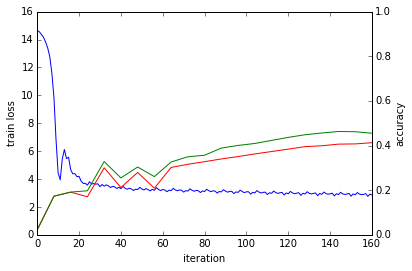

In [40]:
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r',
         test_interval * arange(len(train_acc)), train_acc, 'g')
#ax3 = ax2.twinx()
#ax3.plot(test_interval * arange(len(test_acc)), train_acc, 'g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax1.set_ylim((0,None))
ax2.set_ylabel('accuracy')
ax2.set_ylim((0,1))
#ax3.set_ylabel('test accuracy')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [47]:
labels = classes.index.tolist()
descriptions = classes.description.tolist()
def report(net, iterations):
    y_true = []
    y_pred = []
    for test_it in range(iterations):
        net.forward()
        y_pred.extend(net.blobs['ip2'].data.argmax(1))
        y_true.extend(net.blobs['reshape_labels'].data.argmax(1))
    
    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.classification_report(y_true, y_pred, labels, descriptions))

report(solver.net, TRAIN_EPOCH)

[[ 82   4   0   0   0   0   0  18   1   0  15   0   0   8   0   0]
 [  7  32   0   0   0   0   1  46   0   0   6   0   0   5   0   0]
 [ 10   4   0   0   0   0   0  10   0   0   0   0   0   0   0   0]
 [  5   1   0   0   0   0   0   5   0   0   2   0   0   5   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0]
 [  0   1   0   0   0   0   0   0   0   0   1   0   0   4   0   0]
 [  0   0   0   0   0   0  13   0   0   0   1   0   0   0   0   0]
 [ 17   1   0   0   0   0   1 162   0   0   0   0   0  10   0   0]
 [  9  15   0   0   0   0   0  22   2   0   4   0   0   3   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [ 11  13   0   0   0   0   0   1   0   0 132   0   0   6   0   0]
 [  3   0   0   0   0   0   0   0   0   0   8   0   0   0   0   0]
 [ 11   2   0   0   0   0   0  23   1   0   6   0   0   4   0   0]
 [ 56   5   0   0   0   0   0  35   1   0  58   0   0  43   0   0]
 [  5  32   0   0   0   0   0   7   0   0   1   0   0   5   0 

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0, 1)

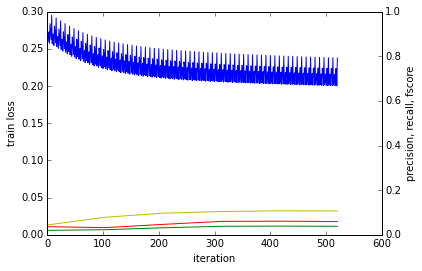

In [24]:
fscore = test_precision * test_recall / (test_precision + test_recall)
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_precision, 'r',
         test_interval * arange(len(train_acc)), test_recall, 'y',
         test_interval * arange(len(train_acc)), fscore, 'g')
#ax3 = ax2.twinx()
#ax3.plot(test_interval * arange(len(test_acc)), train_acc, 'g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax1.set_ylim((0,None))
ax2.set_ylabel('precision, recall, fscore')
ax2.set_ylim((0,1))
#ax3.set_ylabel('test accuracy')

In [ ]:
from shutil import copyfile

results_file = 'results/lenet-2.2nd-try'
if os.path.exists(results_file + '_train_loss.npy'):
    print('File exists! NOT saving!')
else:
    numpy.save(results_file + '_train_loss.npy', train_loss)
    numpy.save(results_file + '_train_acc.npy', train_acc)
    numpy.save(results_file + '_test_acc.npy', test_acc)
    fig.savefig(results_file + '_plot.png')
    copyfile('temp/lenet_auto_train.prototxt', results_file + '_train.prototxt')
    copyfile('temp/autosolver.prototxt', results_file + '_solver.prototxt')

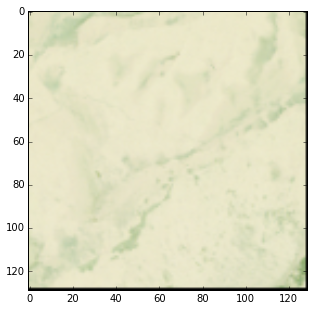

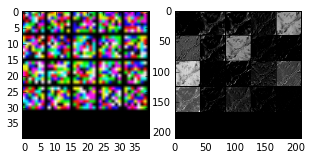

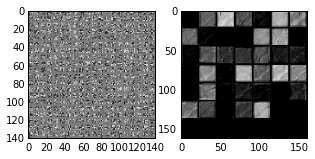

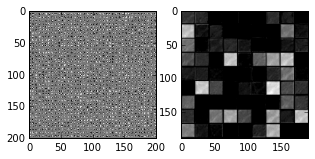

In [32]:
index = 0
plt.rcParams['figure.figsize'] = (5,5)
figure()
vis_square(numpy.array([transformer.deprocess('data', solver.net.blobs['data'].data[index])]))

fig, (ax1, ax2) = subplots(1, 2)
filters = solver.net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1), 1, 0, ax1)
images = solver.net.blobs['ReLU1'].data[index]
vis_square(images, 1, 0, ax2)

fig, (ax1, ax2) = subplots(1, 2)
vis_square(solver.net.params['conv2'][0].data[:20].reshape(20**2, 5, 5), 2, 0, ax1)
vis_square(solver.net.blobs['relu2'].data[index], 2, 0, ax2)

fig, (ax1, ax2) = subplots(1, 2)
vis_square(solver.net.params['conv3'][0].data[:40].reshape(40**2, 3, 3), 2, 0, ax1)
vis_square(solver.net.blobs['relu3'].data[index], 1, 0, ax2)


Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

In [ ]:
for i in range(16):
    figure(figsize=(2, 2))
    imshow(transformer.deprocess('data', solver.test_nets[0].blobs['data'].data[i]))
    figure(figsize=(20, 1))
    #imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    imshow(exp(output[:200, i].T) / exp(output[:200, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')